In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
import numpyro

from jax import random
import jax.numpy as jnp
from numpyro.distributions import Normal
from numpyro.infer import init_to_mean, init_to_value
import warnings
from common_util import setup_axis_default, jmak_fit_model_setup,gl_fit_model_setup,kbar_jmak,kbar_gl,tbar

from typing import Callable, Dict,Tuple, List, Any

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B',
                 'rf_data/yu_data/data.csv': 'Yu et al. (2017)'}

file_to_model =  {'rf_data/alfonso_data/highly_rolled.csv': 'alfonso_data_hr',
                'rf_data/alfonso_data/moderate_roll.csv': 'alfonso_data_mr',
                'rf_data/richou_data/batch_a_data.csv': 'richou_batch_a',
                'rf_data/richou_data/batch_b_data.csv': 'richou_batch_b',
                 'rf_data/yu_data/data.csv': 'yu'}

file_to_multiplier = {'rf_data/alfonso_data/highly_rolled.csv': 3600.,
                      'rf_data/alfonso_data/moderate_roll.csv': 3600.,
                        'rf_data/richou_data/batch_a_data.csv': 1.0,
                        'rf_data/richou_data/batch_b_data.csv': 1.0,
                        'rf_data/yu_data/data.csv': 3600}


c:\Users\mlanahan3\Anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Bayesian Hierarchical Modeling

Let $j = 1,...,m$ number the different data sets and $i = 1,...,n_j$ number the data. We assume that the latent parameters, $\mathbf{c}$ and $\mathbf{d}$ are independent of the particular data set, and the model parameters $a_1,a_2,B_1,B_2,n$ are unique to each data set, but must satisfy equations specified by the relationships above.

$
\mathcal{L}(\mathbf{X},\mathbf{T},\mathbf{t}| \mathbf{c},\mathbf{d}) = X_{ij} - \hat{X}_{ij} \sim \mathcal{N}(0,\sigma^2 \xi_{ij}^2) \\ 
\hat{X}_{ij} = 1 - \exp{\left(-b(T_{ij})^{n_j}(t_{ij} - t_{inc}(T_{ij}))^{n_j}\right)} \\ 
b(T_{ij}) = \exp{\left(a_{1,j} + \frac{B_{1,j}}{T_{ij}}\right)} \\ 
t_{inc}(T_{ij}) = \exp{\left(a_{2,j} + \frac{B_{2,j}}{T_{ij}} \right)} 
$

where the coefficients $a_{1,j},a_{2,j},B_{1,j},B_{2,j},n_j$ satisfy:

$
a_{1,j} =  c_1 n_j (a_{1,j} + T_0 B_{1,j}) + d_1 \\ 
B_{1,j} =  c_2 n_j (a_{1,j} + T_0 B_{1,j}) + d_2 \\ 
n_j = c_3 n_j(a_{1,j} + T_0 B_{1,j}) + d_3  \\ 
B_{1,j} = c_4 a_2 + c_4 B_{2,j} T_0 + d_4 \\ 
a_{2,j}  + B_{2,j} T_0 = c_5 n (a_{1,j} + T_0 B_{1,j}) + d_5
$

and the latent parameters have prior distribution:

$
\mathbf{c} \sim \pi(\mathbf{c}) = \mathcal{N}(\mu_{c},\Sigma_c) \\ 
\mathbf{d} \sim \pi(\mathbf{d}) = \mathcal{N}(\mu_d,\Sigma_d)\\ 
$

for specified $\mu_c,\Sigma_c,\mu_d,\Sigma_d$. We can sample from the posterior of $\mathbf{c}, \mathbf{d}$ as:

$
p(\mathbf{c},\mathbf{d} | \mathbf{X,T,t}) \propto \mathcal{L}(\mathbf{X},\mathbf{T},\mathbf{t}| \mathbf{c},\mathbf{d}) \pi(\mathbf{c}) \pi(\mathbf{d})
$



### Linear Latent Model Inference

In [17]:
from typing import List, Dict, Tuple
from numpyro.distributions import Distribution
from statsmodels.regression.linear_model import OLS, OLSResults
from jax import vmap
from numpyro.distributions import MultivariateNormal, Uniform

def normal_prior_lm(name: str,
                    params: Tuple[jnp.ndarray| np.ndarray],
                    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]) -> Tuple[str,Distribution,Callable]:

    def linear_latent_model(x: jnp.ndarray,p: jnp.ndarray):
        x_ = latent_transform(x)
        y = jnp.sum(x_ * p,axis = -1)
        return y

    return [name,MultivariateNormal(params[0],params[1]),linear_latent_model,None]

def uniform_prior_lm(name: str,
                    params: Tuple[jnp.ndarray| np.ndarray],
                    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]) -> Tuple[str,Distribution,Callable]:

    def linear_latent_model(x: jnp.ndarray,p: jnp.ndarray):
        x_ = latent_transform(x)
        y = jnp.sum(x_ * p,axis = -1)
        return y

    a = params[0] - 3.0*jnp.sqrt(params[1])
    b = params[0] + 3.0*jnp.sqrt(params[1])
    return [name,Uniform(a,b),linear_latent_model,None]

def statsmodels_lm_to_bayesian(name: str,
                               ols: OLSResults,
                               latent_transform: Callable[[jnp.ndarray],jnp.ndarray],
                               prior = 'normal') -> Tuple[str,
                                                        Distribution,
                                                        Callable]:

    try:
        return {'normal':normal_prior_lm(name,(ols.params,50*ols.cov_params()),latent_transform),
        'uniform':uniform_prior_lm(name,(ols.params,50*np.diag(ols.cov_params())),latent_transform)}[prior]
    except KeyError:
        raise ValueError('Invalid prior type. Must be one of "normal" or "uniform"')

def alm(latent_model_tuple: Tuple[jnp.ndarray,Callable], 
                       x: jnp.ndarray) -> jnp.ndarray:
    
    """
    apply the latent model
    """
    _,_,latent_model,latent_params = latent_model_tuple
    return latent_model(x,latent_params)

def slm(latent_model_tuple: List[Any], 
        latent_variable: jnp.ndarray,
        params: jnp.ndarray) -> jnp.ndarray:
    """
    sample latent model output from provided samples
    """
    _,_,latent_model,_ = latent_model_tuple
    latent_model_tuple[-1] = params
    return latent_model(latent_variable,params)

#affine transformations for the latent variables
def log_kbar_tform(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([jnp.ones([x.shape[0],1]),x[...,0:1]],axis = 1)

def log_tbar_tform(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([jnp.ones([x.shape[0],1]),x[...,1:2]],axis = 1)

def jmak_single_model_prediction(t: jnp.ndarray,
                            T: jnp.ndarray,
                            std: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            latent_var : jnp.ndarray,
                            sigma: float) -> Tuple[jnp.ndarray,jnp.ndarray]:
    
    #apply the latent models to the sampled latent variables and latent model parameters
    a1 = alm(latent_models['a1'],latent_var)
    B1 = alm(latent_models['B1'],latent_var)
    n = alm(latent_models['n'],latent_var)
    a2 = alm(latent_models['a2'],latent_var)
    B2 = alm(latent_models['B2'],latent_var)
    #compute the arrhenius parameters from the model parameters
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    
    #compute the model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)

    return Xhat,std + sigma

def gl_single_model_prediction(t: jnp.ndarray,
                            T: jnp.ndarray,
                            std: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            latent_var : jnp.ndarray,
                            sigma: float) -> Tuple[jnp.ndarray,jnp.ndarray]:
    
    #apply the latent models to the sampled latent variables and latent model parameters
    a1 = alm(latent_models['a1'],latent_var)
    B1 = alm(latent_models['B1'],latent_var)
    nu = alm(latent_models['nu'],latent_var)
    a2 = alm(latent_models['a2'],latent_var)
    B2 = alm(latent_models['B2'],latent_var)

    #compute the arrhenius parameters from the model parameters
    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)
    
    #compute the model prediction
    Xhat = (1.+ jnp.exp(-B*(t - M)))**(-1./nu)

    return Xhat,std + sigma


### Hierarchical Model Inference


In [22]:
from numpyro.distributions import Normal, Exponential
rng_key = random.PRNGKey(92)
rng_key, rng_key_ = random.split(rng_key)

#Model Specific Setup
model_name = 'Generalized Logistic_{}'
single_model_prediction = jmak_single_model_prediction if 'JMAK' in model_name else gl_single_model_prediction
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl
ep_param = 'n' if 'JMAK' in model_name else 'nu' 
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup

def jmak_numpyro_hierarchical_model(t: List[jnp.ndarray],
                                    T: List[jnp.ndarray],
                                    X: List[jnp.ndarray],
                                    std: List[jnp.ndarray],
                                    latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                                    latent_means: jnp.ndarray,
                                    latent_std: jnp.ndarray) -> None:
                      
    """
    numpyro/jax numpy compatible model for the JMAK model
    """
    X_ = jnp.concatenate(X)

    # priors for "latent" variables
    latent_dist = Normal(latent_means,latent_std)
    latent_var = numpyro.sample('latent_variables',latent_dist)

    #set-up the latent models
    for p,(name,dist,_,_)  in latent_models.items():
        latent_models[p][-1] = numpyro.sample(name,dist)

    #priors for the model error
    sigma = numpyro.sample('sigma',Exponential(10.0).expand([latent_means.shape[0]]))

    Xhat_list =[]
    std_list = []
    #compute the model predictions and stds for each data set
    for i,(t_,T_,std_) in enumerate(zip(t,T,std)):
        Xhat,std_dev = single_model_prediction(t_,T_,std_,latent_models,latent_var[i:i+1,...],sigma[i])
        Xhat_list.append(Xhat)
        std_list.append(std_dev)
    
    Xhat = jnp.concatenate(Xhat_list)
    tt_std = jnp.concatenate(std_list)

    #sample the joint likelihood
    with numpyro.plate('data',X_.shape[0]):
        numpyro.sample('obs',Normal(Xhat,tt_std),obs = X_)

#read in data and prior estimation for latent variables and parameters
t,T,X,std = [],[],[],[]
T_1 = 800.0 + 273.15
T_2 = 1300.0 + 273.15
latent_means,latent_stds = [],[]

for i,file in enumerate(list(file_to_label.keys())):
    dname = file_to_label[file]
    t_,T_,X_,df,_,_ = model_setup(file, mult = file_to_multiplier[file])
    t.append(jnp.array(t_)),T.append(jnp.array(T_)),X.append(jnp.array(X_))
    
    with open(f'.inference/{model_name.format(dname)}_samples.pkl','rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f)).iloc[::20]

    for row in samples.index:
        with warnings.catch_warnings(action = 'ignore'): 
            samples.loc[row,'k_bar']=  np.log(kbar(samples.loc[row,'a1'],samples.loc[row,'B1'],samples.loc[row,ep_param],T_1,T_2))
            samples.loc[row,'t_bar'] = np.log(tbar(samples.loc[row,'a2'],samples.loc[row,'B2'],T_1,T_2))
    
    latent_means.append(jnp.array(samples[['k_bar','t_bar']].to_numpy().mean(axis = 0)))
    latent_stds.append(jnp.array(samples[['k_bar','t_bar']].to_numpy().std(axis = 0)))
    std.append(jnp.array(df['std'].to_numpy()))

latent_means = jnp.array(latent_means)
latent_stds = jnp.array(latent_stds)

#read in prior linear models fitted in seperate notebook to help the inference
with open(f'.inference/{model_name.format('prior_linear_models')}.pkl','rb') as f:  
    linear_models = pickle.load(f)

latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform,prior = 'normal') for param in ['a1','B1',ep_param]}
latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform,prior = 'normal') for param in ['a2','B2']})

#setup the MCMC method
nuts_kernel = numpyro.infer.NUTS(jmak_numpyro_hierarchical_model,init_strategy= init_to_mean)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=10000,
    num_warmup=5000,
    num_chains= 1
)

#run the MCMC
mcmc.run(rng_key_,t,T,X,std,latent_models,latent_means,latent_stds)
mcmc.print_summary()

with open(f'.inference/{model_name.format("hierarchical")}_samples.pkl','wb') as f:
    pickle.dump(mcmc.get_samples(),f)

No standard deviation column found, using 0.001 for all values


sample: 100%|██████████| 15000/15000 [17:23<00:00, 14.38it/s, 1023 steps of size 3.42e-03. acc. prob=0.96]



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                B1[0]  17444.62      0.43  17444.20  17444.20  17444.20      0.50      1.00
                B1[1]  -3006.09      9.63  -3006.09  -3022.49  -2990.92   8190.88      1.00
                B2[0]  29604.65   2236.23  29615.28  26009.05  33288.65   5895.09      1.00
                B2[1]    928.67     88.88    927.83    787.49   1078.80   5913.52      1.00
                a1[0]    -16.73      0.22    -16.73    -17.10    -16.38   3268.43      1.00
                a1[1]      1.76      0.01      1.76      1.74      1.78   3512.02      1.00
                a2[0]    -29.76      1.60    -29.74    -32.27    -27.05   6052.70      1.00
                a2[1]      0.27      0.07      0.27      0.16      0.38   5680.59      1.00
latent_variables[0,0]     15.93      0.30     15.93     15.45     16.43   4227.41      1.00
latent_variables[0,1]     21.83      1.16     21.83     19.97     23.73   3674.

### Hierarchical Model Maximum Likelihood Estimation

In [23]:
import jax
from common_util import resampled_adam

#Model Specific Setup
model_name = 'Generalized Logistic_{}'
single_model_prediction = jmak_single_model_prediction if 'JMAK' in model_name else gl_single_model_prediction
kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl
ep_param = 'n' if 'JMAK' in model_name else 'nu' 
model_setup = jmak_fit_model_setup if 'JMAK' in model_name else gl_fit_model_setup

#read in prior linear models fitted in seperate notebook
with open(f'.inference/{model_name.format('prior_linear_models')}.pkl','rb') as f:  
    linear_models = pickle.load(f)

latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform) for param in ['a1','B1',ep_param]}
latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform) for param in ['a2','B2']})

def param_map(params: jnp.ndarray) -> Tuple[jnp.ndarray]:

    a1 = params[:2]
    B1 = params[2:4]
    n = params[4:6]
    a2 = params[6:8]
    B2 = params[8:10]
    latent_var = params[10:-5].reshape((5,2))
    sigma = params[-5:]
    return a1,B1,n,a2,B2,latent_var,sigma
                    
def model_likelihood(params: jnp.ndarray,
                    t: List[jnp.ndarray],
                    T: List[jnp.ndarray],
                    X: List[jnp.ndarray],
                    std: List[jnp.ndarray]) -> float:
    
    a1,B1,n,a2,B2,latent_var,log_error = param_map(params)
    latent_models['a1'][-1] = a1
    latent_models['B1'][-1] = B1
    latent_models[ep_param][-1] = n
    latent_models['a2'][-1] = a2
    latent_models['B2'][-1] = B2
    X_ = jnp.concatenate(X)
    #compute the model predictions and stds for each data set
    Xhat_list =[]
    std_list = []
    #compute the model predictions and stds for each data set
    for i,(t_,T_,std_) in enumerate(zip(t,T,std)):
        Xhat,std_dev = single_model_prediction(t_,T_,std_,latent_models,latent_var[i:i+1,...],jnp.exp(log_error[i]))
        Xhat_list.append(Xhat)
        std_list.append(std_dev)
    
    Xhat = jnp.concatenate(Xhat_list)
    tt_std = jnp.concatenate(std_list)

    #sample the joint likelihood
    return Normal(Xhat,tt_std).log_prob(X_).sum()

 #read in data from all the models
t,T,X,std = [],[],[],[]
for i,file in enumerate(list(file_to_label.keys())):
    dname = file_to_label[file]
    t_,T_,X_,df,_,_ = model_setup(file, mult = file_to_multiplier[file])
    t.append(jnp.array(t_)),T.append(jnp.array(T_)),X.append(jnp.array(X_))
    std.append(jnp.array(df['std'].to_numpy()))

#define optimization function
def opt_func(params: jnp.ndarray):
    return -model_likelihood(params,
                            t,T,X,std)

model_params = ['a1','B1',ep_param,'a2','B2','latent_variables','sigma']
with open(f'.inference/{model_name.format("hierarchical")}_samples.pkl','rb') as f:
    posterior_samples = pickle.load(f)

posterior_samples = {key: jnp.array(posterior_samples[key]) for key in model_params}
posterior_samples['sigma'] = jnp.log(posterior_samples['sigma'])

array_samples = jnp.concat([posterior_samples[key].reshape((posterior_samples[key].shape[0],-1)) for key in model_params],axis = 1)
NUM_SAMPLES = 25

posterior_likelihood = jax.vmap(opt_func,
                                in_axes = (0))(array_samples)

best_sample_index = np.argsort(posterior_likelihood)[:NUM_SAMPLES]

init_samples = array_samples[best_sample_index]
opt_params,posterior_value = resampled_adam(init_samples,opt_func,lr = 2.5e-4,opt_iter = int(2e3))
a1,B1,n,a2,B2,latent_var,log_error = param_map(opt_params)

opt_params = {'a1': a1,
              'B1': B1,
              ep_param: n,
              'a2': a2,
              'B2': B2,
              'latent_variables': latent_var,
              'sigma': jnp.exp(log_error)}

inf_summary = {'ml': opt_params,
               'mean': {key: jnp.mean(posterior_samples[key],axis = 0) for key in model_params},
               'std': {key: jnp.std(posterior_samples[key],axis = 0) for key in model_params}}

with open(f'.inference/{model_name.format("hierarchical")}_params.pkl','wb') as f:
    pickle.dump(inf_summary,f)


No standard deviation column found, using 0.001 for all values


Optimizing: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


### Posterior Predictive Distributions

No standard deviation column found, using 0.001 for all values
No standard deviation column found, using 0.001 for all values


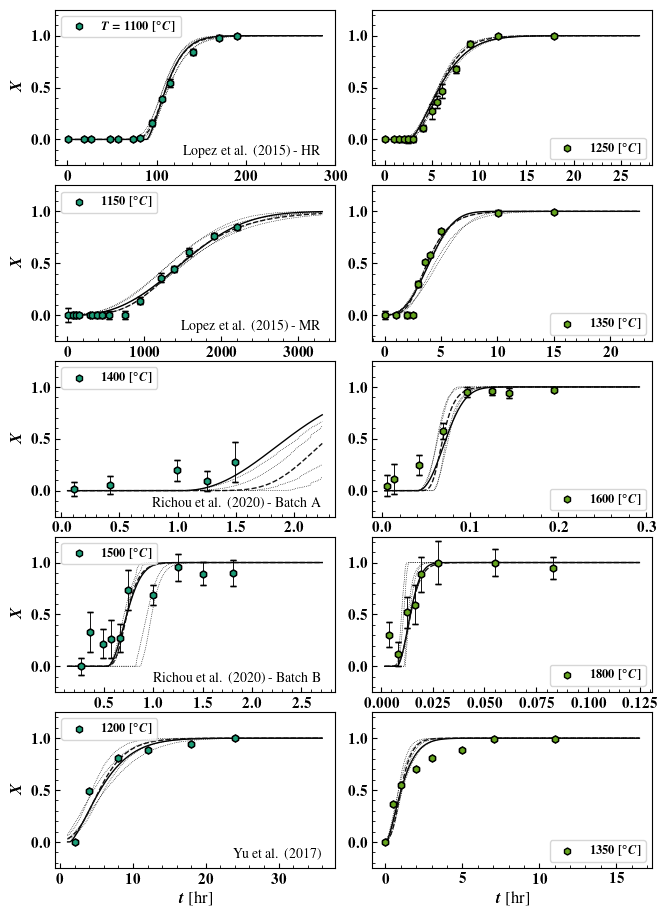

In [26]:
def jmak_posterior_predictive(t: jnp.ndarray,
                              T: jnp.ndarray,
                              latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                              a1_coeff: jnp.ndarray,
                              B1_coeff: jnp.ndarray,
                              n_coeff: jnp.ndarray,
                              a2_coeff: jnp.ndarray,
                              B2_coeff: jnp.ndarray,
                              latent_variables : jnp.ndarray) -> jnp.ndarray:
    
    #sample the latent model variables and latent parameters
    a1 = slm(latent_models['a1'],latent_variables,a1_coeff)[np.newaxis,...]
    B1 = slm(latent_models['B1'],latent_variables,B1_coeff)[np.newaxis,...]
    n = slm(latent_models['n'],latent_variables,n_coeff)[np.newaxis,...]
    a2 = slm(latent_models['a2'],latent_variables,a2_coeff)[np.newaxis,...]
    B2 = slm(latent_models['B2'],latent_variables,B2_coeff)[np.newaxis,...]

    #compute the model prediction using the samples
    b = np.exp(a1 + B1/T[...,np.newaxis])
    t_inc = np.exp(a2 + B2/T[...,np.newaxis])
    t_eff = t[...,np.newaxis] - t_inc
    t_eff[t_eff < 0.] = 0.0   

    Xhat = 1.0 - np.exp(-b**n*t_eff**n)
    return Xhat

def gl_posterior_predictive(t: jnp.ndarray,
                            T: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            a1_coeff: jnp.ndarray,
                            B1_coeff: jnp.ndarray,
                            nu_coeff: jnp.ndarray,
                            a2_coeff: jnp.ndarray,
                            B2_coeff: jnp.ndarray,
                            latent_variables : jnp.ndarray) -> jnp.ndarray:
    
    a1 = slm(latent_models['a1'],latent_variables,a1_coeff)[np.newaxis,...]
    B1 = slm(latent_models['B1'],latent_variables,B1_coeff)[np.newaxis,...]
    nu = slm(latent_models['nu'],latent_variables,nu_coeff)[np.newaxis,...]
    a2 = slm(latent_models['a2'],latent_variables,a2_coeff)[np.newaxis,...]
    B2 = slm(latent_models['B2'],latent_variables,B2_coeff)[np.newaxis,...]

    B = np.exp(a1 + B1/T[...,np.newaxis])
    M = np.exp(a2 + B2/T[...,np.newaxis])

    Xhat = (1.+ np.exp(-B*(t[...,np.newaxis] - M)))**(-1./nu)
    return Xhat

def plot_posterior_prediction(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: Dict[str,np.ndarray], 
                              temperature: float,
                              exp_data: pd.DataFrame,
                              posterior_samples: Dict[str,np.ndarray],
                              latent_models: Dict[str,Tuple[np.ndarray,Callable]],
                              style: str = '-',
                              pred_color: str = 'k',
                              model_params = ['a1','B1','n','a2','B2','latent_variables']) -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    data = exp_data.loc[df['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    predictions = model_func(t,(temperature + 273.15)*np.ones_like(t),
                             latent_models,*(posterior_samples[key] for key in model_params))

    #Estimate using ML parameters
    ml_pred = model_func(t,(temperature + 273.15)*np.ones_like(t),
                        latent_models,*(ml_est[key][np.newaxis,:] for key in model_params))

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions.T,0.95)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    
def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[df['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 25,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

#plot the posterior predictive for the JMAK and GLM models for some sample isothermal temperatures
fig,axes = plt.subplots(nrows = 5,ncols = 2,figsize = (6.5,9))

file_to_index = {file: i for i,file in enumerate(list(file_to_label.keys()))}   
temperatures  = {'rf_data/alfonso_data/highly_rolled.csv': [1100,1250],
                'rf_data/alfonso_data/moderate_roll.csv': [1150,1350],
                'rf_data/richou_data/batch_a_data.csv': [1400,1600],
                'rf_data/richou_data/batch_b_data.csv': [1500,1800],
                 'rf_data/yu_data/data.csv': [1200,1350]}

for k,model_name,model_func,model_setup,ep_param,color,style in zip(range(2),['JMAK_{}','Generalized Logistic_{}'],
                                             [jmak_posterior_predictive,gl_posterior_predictive],
                                             [jmak_fit_model_setup,gl_fit_model_setup],
                                             ['n','nu'],
                                             ['k',(20/255,20/255,20/255)],
                                             ['-','--']):

    with open(f'.inference/{model_name.format("hierarchical")}_samples.pkl','rb') as f:
        posterior_samples = pickle.load(f)
    
    with open(f'.inference/{model_name.format("hierarchical")}_params.pkl','rb') as f:
        inf_summary = pickle.load(f)

    with open(f'.inference/{model_name.format('prior_linear_models')}.pkl','rb') as f:  
        linear_models = pickle.load(f)

    latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform,prior = 'uniform') for param in ['a1','B1',ep_param]}
    latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform,prior = 'uniform') for param in ['a2','B2']})

    ml_params = inf_summary['ml']
    ml_latent_var = ml_params['latent_variables'].copy()
    posterior_samples_latent_var= posterior_samples['latent_variables'].copy()

    for i,file in enumerate(file_to_label.keys()): #count rows/datasets
        ml_params['latent_variables'] = ml_latent_var[file_to_index[file]]
        posterior_samples['latent_variables'] = posterior_samples_latent_var[:,file_to_index[file],:]
        t,T,X,df,bounds,p0 = model_setup(file, mult = file_to_multiplier[file])
        for j,plot_temperature,exp_color in zip(range(2),temperatures[file],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
            plot_posterior_prediction(axes[i,j],model_func,ml_params,
                                      plot_temperature,df,posterior_samples,latent_models,style = style,pred_color = color,
                                    model_params = ['a1','B1',ep_param,'a2','B2','latent_variables'])
            plot_experimental_data(axes[i,j],df,plot_temperature,exp_color,first_label = (i == 0 and j == 0),
                                   make_label = k == 0)

for ax,data_label in zip(axes[:,0],file_to_label.values()):
    ax.set_ylabel(r'$X$',fontsize = 12)
    ax.text(0.95, 0.05, data_label , ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

for ax in axes[-1,:]:
    ax.set_xlabel(r'$t$ [hr]',fontsize = 12)

for i in range(5):
    for j in range(2):
        setup_axis_default(axes[i,j])
        axes[i,j].set_ylim([-0.25,1.25])
        #ax.set_xscale('log')   
        #final formatting
        if j == 1:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'lower right')
        else:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'upper left')
        

fig.tight_layout(pad = 0.1) 
fig.savefig('.git_images/posterior_predictive_comparison_hierarchical.svg')
